In [1]:
#setup
data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='BSBSSSBB'
meas='TMIN'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+---------+------+--------------------+------+
| 141.25515170176357| 152.24605721027376|  143.4917267656344|     71.6|BSBSSSBB| 32.1833| -82.5667|       TMIN|0.9894301354732532|0.9391449767722246|0.9179009528561886|0.08227201305904994|USC00090090|7250717.0|    11|[80 51 40 52 00 0...|1948.0|
| 193.7134408577

### Plot Mean and Eigenvecs

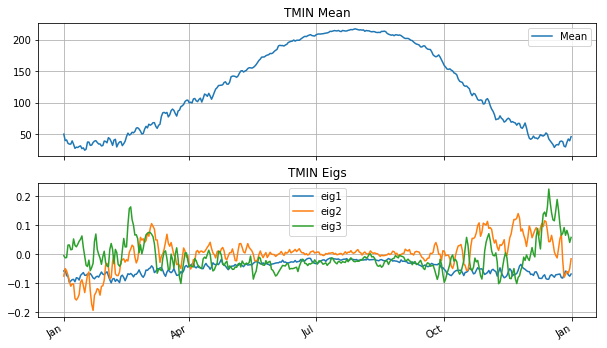

In [7]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

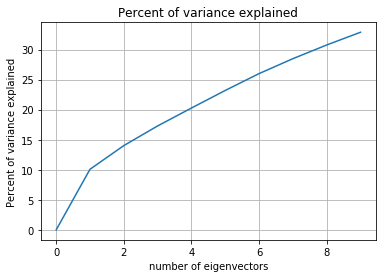

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [9]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

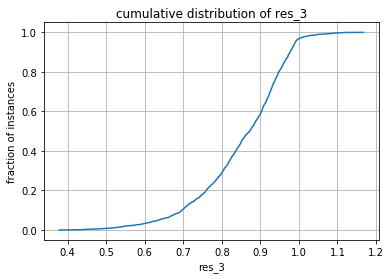

In [10]:
plot_CDF(df,'res_3')

In [11]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00090090', 1948.0)

In [12]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

43800

In [13]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [14]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [15]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00094238 1424
USC00098351 6008
USC00095696 1447
USC00093840 337
USC00094429 19176
USC00092839 34206
USC00095858 343
USC00095811 12888
USW00013861 5382
USC00092844 726
USC00095740 329
USC00090670 2880
USC00096255 1093
USW00013857 3254
USW00013870 23320
USC00098476 15560
USW00093845 8261
USC00093325 7055
USC00099020 730
USC00094110 5020
USC00095874 39180
USC00097777 19353
USR0000FOLU 2190
USC00093312 3501
USC00096237 9543
USR0000GJON 3612
USC00089640 2491
USC00094862 2860
USC00084393 6349
USC00084394 22140
USC00093386 28228
USC00090131 24907
USR0000GBAX 2519
USC00092966 38492
USC00095401 1330
USR0000GMCR 2537
USC00096838 2485
USC00098972 5680
USC00097171 4357
USC00094170 36981
USC00090010 2764
USC00099186 38652
USC00093465 21090
USC00094971 1094
USC00094594 14239
USC00094204 11921
USC00095386 13028
USC00096244 3579
USC00099451 1418
USC00084731 41967
USC00098974 16240
USC00090090 7393
USC00095863 16668
USC00085275 34959
USC00090190 1411
USC00092865 2542
USC00092783 24527
USR0000GLOU 25

In [16]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(70, 43800)


In [17]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  148.082886284
RMS removing mean-by-station=  79.821452328
RMS removing mean-by-day   =  21.5192420375


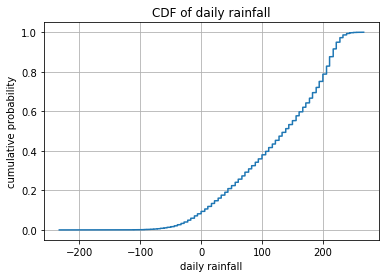

In [18]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [19]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [20]:
#USC00193270 21482
#USC00193702 28237
#USC00094238 1424
#USC00098351 3393
X=copy(All['USC00092783'])
Y=copy(All['USC00098351'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


24527
6008
2833
2833


In [21]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)

m=2833,l=2515,n1=2669,n2=2524,LogPval=-0.125033
(-0.12503289774988402, 2833)


### calculate the normalized log probability for each pair of stations.

In [22]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 m=2452,l=2261,n1=2302,n2=2280,LogPval=-0.147518
m=17148,l=15399,n1=15755,n2=15606,LogPval=-0.169177
m=25739,l=23739,n1=23840,n2=24588,LogPval=-0.106686
m=16929,l=15419,n1=15574,n2=15876,LogPval=-0.130669
m=24269,l=22304,n1=22486,n2=23070,LogPval=-0.103099
m=2398,l=2156,n1=2161,n2=2293,LogPval=-0.098374
m=2654,l=2275,n1=2413,n2=2316,LogPval=-0.141506
m=5910,l=5176,n1=5476,n2=5243,LogPval=-0.124520
m=15390,l=13795,n1=14321,n2=13976,LogPval=-0.128990
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2777,l=2445,n1=2512,n2=2499,LogPval=-0.166600
m=18886,l=16768,n1=17426,n2=17176,LogPval=-0.109839
m=24863,l=21697,n1=23068,n2=21942,LogPval=-0.124108
m=707,l=613,n1=658,n2=616,LogPval=-0.137428
m=0,l=0,n1=0,n2=0,LogPval=nan
m=25931,l=23178,n1=24026,n2=23708,LogPval=-0.107761
m=1025,l=873,n1=973,n2=876,LogPval=-0.090317
m=3498,l=3170,n1=3278,n2=3233,LogPval=-0.095573
m=6477,l=5805,n1=5905,n2=5994,LogPval=-0.131399
m=20108,l=18262,n1=18617,n2=18810,LogPval=-0.103316
m=17352,l=15873,n1=15997,n2=16381,LogPval=-0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


m=5671,l=5079,n1=5257,n2=5111,LogPval=-0.165710
m=10466,l=9461,n1=9811,n2=9520,LogPval=-0.140413
m=0,l=0,n1=0,n2=0,LogPval=nan
m=21494,l=18880,n1=20161,n2=18971,LogPval=-0.124435
m=1379,l=1208,n1=1296,n2=1219,LogPval=-0.103442
m=2060,l=1888,n1=1932,n2=1916,LogPval=-0.119770
m=2385,l=2165,n1=2238,n2=2180,LogPval=-0.138622
m=2417,l=2249,n1=2270,n2=2287,LogPval=-0.126127
m=3449,l=3170,n1=3219,n2=3231,LogPval=-0.124182
m=2399,l=2038,n1=2252,n2=2048,LogPval=-0.107015
m=2396,l=2140,n1=2256,n2=2163,LogPval=-0.102925
m=2402,l=2115,n1=2255,n2=2126,LogPval=-0.122685
m=2409,l=2178,n1=2262,n2=2198,LogPval=-0.124402
m=2388,l=2206,n1=2244,n2=2236,LogPval=-0.126133
m=2873,l=2682,n1=2691,n2=2761,LogPval=-0.100911
m=5332,l=4931,n1=5008,n2=4994,LogPval=-0.132050
m=21501,l=19548,n1=20085,n2=19765,LogPval=-0.137412
m=6203,l=5696,n1=5846,n2=5751,LogPval=-0.124194
5 m=24269,l=22304,n1=23070,n2=22486,LogPval=-0.103099
m=4873,l=4514,n1=4666,n2=4568,LogPval=-0.072666
m=18313,l=16465,n1=17205,n2=16584,LogPval=-

m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=357,l=314,n1=318,n2=333,LogPval=-0.113957
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
11 m=2777,l=2445,n1=2499,n2=2512,LogPval=-0.166600
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2878,l=2539,n1=2595,n2=2601,LogPv

m=1416,l=1302,n1=1322,n2=1323,LogPval=-0.134952
m=18610,l=16156,n1=16701,n2=16667,LogPval=-0.146213
m=14106,l=12344,n1=12711,n2=12690,LogPval=-0.152878
m=2780,l=2316,n1=2496,n2=2348,LogPval=-0.164171
m=1092,l=960,n1=986,n2=1011,LogPval=-0.088889
m=32159,l=28132,n1=29339,n2=28510,LogPval=-0.162751
m=12164,l=10361,n1=10928,n2=10530,LogPval=-0.170939
m=1327,l=1145,n1=1200,n2=1166,LogPval=-0.159791
m=1020,l=866,n1=909,n2=890,LogPval=-0.156773
m=1447,l=1131,n1=1301,n2=1133,LogPval=-0.167963
m=329,l=295,n1=304,n2=295,LogPval=-0.207256
m=12023,l=10612,n1=10721,n2=11032,LogPval=-0.166162
m=343,l=316,n1=323,n2=328,LogPval=-0.045946
m=16132,l=14037,n1=14507,n2=14387,LogPval=-0.161804
m=36541,l=30736,n1=33404,n2=30911,LogPval=-0.156772
m=8682,l=7533,n1=7684,n2=7780,LogPval=-0.183975
m=3571,l=3156,n1=3263,n2=3267,LogPval=-0.103593
m=334,l=293,n1=305,n2=301,LogPval=-0.123859
m=1062,l=958,n1=975,n2=997,LogPval=-0.094948
m=2415,l=2108,n1=2167,n2=2178,LogPval=-0.148648
m=4272,l=3742,n1=3852,n2=3843,Lo

m=2499,l=2204,n1=2372,n2=2205,LogPval=-0.117398
m=2508,l=2281,n1=2381,n2=2285,LogPval=-0.128009
m=2487,l=2320,n1=2363,n2=2327,LogPval=-0.142004
m=2367,l=2215,n1=2225,n2=2279,LogPval=-0.091220
m=4496,l=4173,n1=4229,n2=4214,LogPval=-0.143117
m=20393,l=18681,n1=19179,n2=18813,LogPval=-0.138973
m=7280,l=6728,n1=6915,n2=6767,LogPval=-0.120035
22 m=0,l=0,n1=0,n2=0,LogPval=nan
m=295,l=253,n1=256,n2=277,LogPval=-0.090377
m=0,l=0,n1=0,n2=0,LogPval=nan
m=337,l=297,n1=298,n2=328,LogPval=-0.047000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=330,l=290,n1=291,n2=316,LogPval=-0.082501
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=297,l=263,n1=267,n2=275,LogPval=-0.129864
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=337,l=285,n1=298,n2=294,LogPval=-0.164731
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=337,l=296,n1=298,n2=313,LogPval=-0.144526
m=325,l=281,n1=287,n2=284,LogPval=-0.258777
m=0,l=0,n1=0,n2=0,L

m=8767,l=7777,n1=7938,n2=7851,LogPval=-0.216866
m=3562,l=3099,n1=3167,n2=3256,LogPval=-0.126932
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1063,l=937,n1=947,n2=997,LogPval=-0.106527
m=2424,l=2074,n1=2091,n2=2179,LogPval=-0.201808
m=4285,l=3667,n1=3706,n2=3841,LogPval=-0.200358
m=0,l=0,n1=0,n2=0,LogPval=nan
m=17807,l=15153,n1=15991,n2=15408,LogPval=-0.169491
m=0,l=0,n1=0,n2=0,LogPval=nan
m=14379,l=12645,n1=12971,n2=12858,LogPval=-0.190286
m=13310,l=11586,n1=11997,n2=11832,LogPval=-0.166808
m=5626,l=5009,n1=5139,n2=5065,LogPval=-0.186179
m=7414,l=6481,n1=6561,n2=6700,LogPval=-0.193399
m=0,l=0,n1=0,n2=0,LogPval=nan
m=17474,l=14959,n1=15610,n2=15218,LogPval=-0.187030
m=1407,l=1176,n1=1227,n2=1242,LogPval=-0.128206
m=2144,l=1802,n1=1817,n2=1989,LogPval=-0.115794
m=2473,l=2100,n1=2109,n2=2257,LogPval=-0.172885
m=2508,l=2140,n1=2143,n2=2372,LogPval=-0.106778
m=3564,l=3038,n1=3052,n2=3338,LogPval=-0.114294
m=2490,l=2031,n1=2125,n2=2119,LogPval=-0.186339
m=2480,l=2081,n1=2131,n2=2232,LogPval=-0.134207
m=2

m=655,l=565,n1=574,n2=583,LogPval=-0.212048
m=1322,l=1143,n1=1158,n2=1195,LogPval=-0.179550
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1302,l=1076,n1=1139,n2=1103,LogPval=-0.185819
m=1304,l=1116,n1=1144,n2=1174,LogPval=-0.144722
m=349,l=290,n1=317,n2=291,LogPval=-0.174380
m=651,l=554,n1=561,n2=598,LogPval=-0.130915
m=1325,l=1098,n1=1161,n2=1114,LogPval=-0.215360
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1312,l=1134,n1=1148,n2=1179,LogPval=-0.198224
m=1319,l=1075,n1=1158,n2=1095,LogPval=-0.184792
m=0,l=0,n1=0,n2=0,LogPval=nan
m=305,l=257,n1=267,n2=270,LogPval=-0.141102
m=0,l=0,n1=0,n2=0,LogPval=nan
m=317,l=265,n1=266,n2=296,LogPval=-0.117711
m=341,l=306,n1=313,n2=313,LogPval=-0.142664
m=994,l=854,n1=873,n2=883,LogPval=-0.192537
m=0,l=0,n1=0,n2=0,LogPval=nan
m=981,l=824,n1=861,n2=835,LogPval=-0.229077
m=0,l=0,n1=0,n2=0,LogPval=nan
m=654,l=558,n1=573,n2=570,LogP

m=0,l=0,n1=0,n2=0,LogPval=nan
m=2813,l=2493,n1=2528,n2=2550,LogPval=-0.194908
m=15154,l=13072,n1=13476,n2=13550,LogPval=-0.152035
m=14616,l=12376,n1=13022,n2=12579,LogPval=-0.186595
m=697,l=609,n1=634,n2=612,LogPval=-0.203673
m=0,l=0,n1=0,n2=0,LogPval=nan
m=16132,l=14037,n1=14387,n2=14507,LogPval=-0.161804
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=6200,l=5478,n1=5555,n2=5755,LogPval=-0.122083
m=13566,l=11956,n1=12075,n2=12601,LogPval=-0.132339
m=15340,l=13617,n1=13698,n2=14483,LogPval=-0.109232
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=15566,l=13326,n1=13832,n2=13603,LogPval=-0.190740
m=4584,l=4054,n1=4114,n2=4164,LogPval=-0.182639
m=0,l=0,n1=0,n2=0,LogPval=nan
m=15815,l=13665,n1=14096,n2=14111,LogPval=-0.157875
m=11491,l=10005,n1=10305,n2=10343,LogPval=-0.145402
m=2796,l=2352,n1=2513,n2=2371,LogPval=-0.188016
m=1073,l=942,n1=961,n2=992,LogPval=-0.110615
m=15873,l=13603,n1=14124,n2=13827,LogPval=-0.201779
m=8196,l=6854,n1=7207,n2=7048,LogPval=-0.

m=693,l=648,n1=650,n2=663,LogPval=-0.119672
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1064,l=981,n1=998,n2=997,LogPval=-0.121220
m=1055,l=977,n1=995,n2=992,LogPval=-0.110293
45 m=2423,l=2139,n1=2182,n2=2194,LogPval=-0.172997
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2483,l=2191,n1=2237,n2=2247,LogPval=-0.171439
m=2414,l=2157,n1=2174,n2=2298,LogPval=-0.085017
m=2338,l=2105,n1=2115,n2=2211,LogPval=-0.118603
m=1712,l=1509,n1=1536,n2=1582,LogPval=-0.120799
m=2066,l=1842,n1=1846,n2=1972,LogPval=-0.099853
m=1320,l=1138,n1=1187,n2=1165,LogPval=-0.157719
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2452,l=2153,n1=2207,n2=2206,LogPval=-0.170998
m=1782,l=1551,n1=1577,n2=1601,LogPval=-0.191266
m=976,l=841,n1=888,n2=861,LogPval=-0.127799
m=721,l=627,n1=675,n2=630,LogPval=-0.125233
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2415,l=2108,n1=2178,n2=2167,LogPval=-0.148648
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2436,l=2174,n1=2194,n2=

m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1414,l=1271,n1=1275,n2=1354,LogPval=-0.091160
m=5329,l=4820,n1=4848,n2=4994,LogPval=-0.143774
m=15520,l=13816,n1=13879,n2=14342,LogPval=-0.176527
m=2438,l=2124,n1=2157,n2=2236,LogPval=-0.139058
51 m=10157,l=8872,n1=9055,n2=9357,LogPval=-0.113482
m=297,l=267,n1=269,n2=280,LogPval=-0.117478
m=14031,l=12192,n1=12494,n2=12748,LogPval=-0.133011
m=14253,l=12607,n1=12695,n2=13438,LogPval=-0.106964
m=13958,l=12280,n1=12408,n2=12993,LogPval=-0.123922
m=12091,l=10680,n1=10733,n2=11401,LogPval=-0.113746
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=5442,l=4652,n1=4782,n2=4778,LogPval=-0.202564
m=6350,l=5408,n1=5595,n2=5606,LogPval=-0.164227
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=13640,l=11700,n1=12116,n2=12097,LogPval=-0.156343
m=14528,l=12240,n1=12934,n2=12411,LogPval=-0.191823
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=14210,l=12384,n1=12660,n2=12725,LogPval=-0.184081
m=0,l=0,

m=0,l=0,n1=0,n2=0,LogPval=nan
m=1416,l=1189,n1=1252,n2=1236,LogPval=-0.136685
m=0,l=0,n1=0,n2=0,LogPval=nan
m=333,l=299,n1=302,n2=310,LogPval=-0.143001
m=333,l=301,n1=302,n2=317,LogPval=-0.110093
m=1380,l=1211,n1=1217,n2=1287,LogPval=-0.138850
m=315,l=256,n1=284,n2=258,LogPval=-0.162074
m=328,l=293,n1=298,n2=302,LogPval=-0.146947
m=333,l=289,n1=302,n2=297,LogPval=-0.132457
m=333,l=294,n1=302,n2=303,LogPval=-0.139444
m=328,l=294,n1=298,n2=307,LogPval=-0.114110
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1418,l=1239,n1=1253,n2=1301,LogPval=-0.154864
m=1364,l=1211,n1=1227,n2=1272,LogPval=-0.116762
57 m=2104,l=1860,n1=1952,n2=1885,LogPval=-0.126393
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2189,l=1936,n1=2034,n2=1965,LogPval=-0.117562
m=2116,l=1948,n1=1963,n2=2014,LogPval=-0.102994
m=2060,l=1888,n1=1916,n2=1932,LogPval=-0.119770
m=1392,l=1239,n1=1284,n2=1269,LogPval=-0.114231
m=2146,l=1975,n1=1994,n2=2049,LogPval=-0.085957
m=1710,l=1497,n1=1607,n2=1510,LogPval=-0.104501
m=0,l=0,n1=

m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2063,l=1829,n1=1855,n2=1921,LogPval=-0.116099
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2523,l=2143,n1=2275,n2=2203,LogPval=-0.127178
m=328,l=293,n1=302,n2=298,LogPval=-0.146947
m=2166,l=1924,n1=1945,n2=2022,LogPval=-0.121744
m=2490,l=2212,n1=2242,n2=2286,LogPval=-0.159599
m=2525,l=2272,n1=2277,n2=2392,LogPval=-0.124733
m=2160,l=1921,n1=1935,n2=2045,LogPval=-0.098770
m=2507,l=2129,n1=2259,n2=2149,LogPval=-0.184662
m=2508,l=2191,n1=2260,n2=2228,LogPval=-0.185992
m=2517,l=2237,n1=2269,n2=2306,LogPval=-0.163750
m=2501,l=2242,n1=2259,n2=2346,LogPval=-0.127005
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2525,l=2251,n1=2277,n2=2328,LogPval=-0.157535
m=2509,l=2238,n1=2267,n2=2331,LogPval=-0.130784
63 m=2440,l=2096,n1=2152,n2=2189,LogPval=-0.151636
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2536,l=2178,n1=2241,n2=2283,LogPval=-0.136550
m=2462,l=2158,n1=2170,n2=2343,LogPval=-0.086238
m=2402,l=2115,n1=2126,n

m=2485,l=2215,n1=2286,n2=2239,LogPval=-0.166817
m=4357,l=3864,n1=4009,n2=3912,LogPval=-0.155077
m=0,l=0,n1=0,n2=0,LogPval=nan
m=19344,l=16689,n1=17882,n2=16789,LogPval=-0.145081
m=0,l=0,n1=0,n2=0,LogPval=nan
m=15520,l=13816,n1=14342,n2=13879,LogPval=-0.176527
m=14386,l=12669,n1=13226,n2=12800,LogPval=-0.158267
m=5676,l=5073,n1=5248,n2=5115,LogPval=-0.163541
m=8946,l=7919,n1=8083,n2=8076,LogPval=-0.183932
m=0,l=0,n1=0,n2=0,LogPval=nan
m=21600,l=18833,n1=19876,n2=19028,LogPval=-0.147728
m=1418,l=1239,n1=1301,n2=1253,LogPval=-0.154864
m=2190,l=1985,n1=2007,n2=2035,LogPval=-0.152119
m=2519,l=2289,n1=2310,n2=2302,LogPval=-0.227130
m=2554,l=2341,n1=2345,n2=2418,LogPval=-0.143022
m=3581,l=3250,n1=3271,n2=3355,LogPval=-0.145100
m=2536,l=2159,n1=2327,n2=2163,LogPval=-0.172397
m=2525,l=2251,n1=2328,n2=2277,LogPval=-0.157535
m=2537,l=2241,n1=2328,n2=2242,LogPval=-0.210758
m=2546,l=2306,n1=2337,n2=2322,LogPval=-0.211448
m=2525,l=2319,n1=2322,n2=2365,LogPval=-0.184326
m=3254,l=2915,n1=2915,n2=3133,

In [23]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[    0.  2452.]
 [ 2452.     0.]]
[[-0.4      -0.147518]
 [-0.147518 -0.4     ]]


(4900,) (2978,)


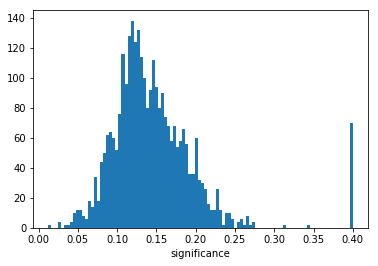

In [24]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

In [25]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

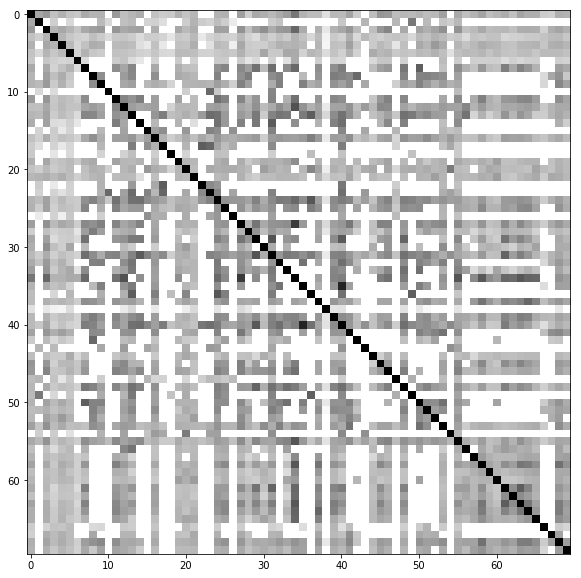

In [26]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [27]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USC00094238', u'USC00098351', u'USC00095696', u'USC00093840', u'USC00094429', u'USC00092839', u'USC00095858', u'USC00095811']


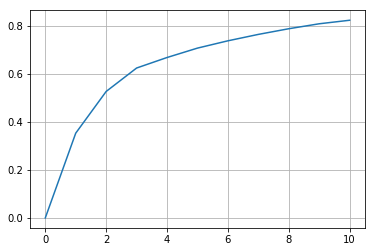

In [28]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [29]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

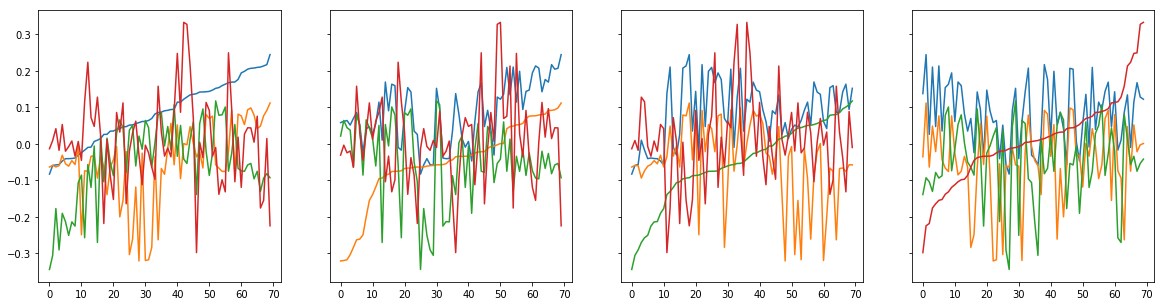

In [30]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [31]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

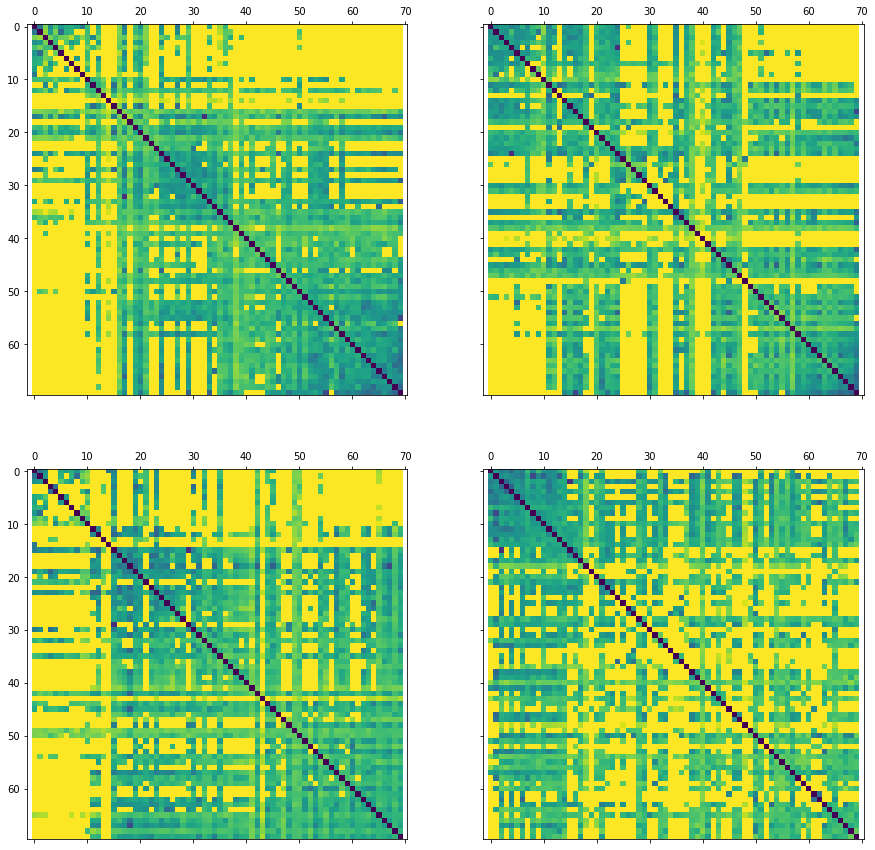

In [32]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1

### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [34]:
from pickle import dump
with open(data_dir+'/'+ meas+'_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    